In [31]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import os
original_dir = os.getcwd()
if os.path.basename(original_dir) == "SupervisedModels":
    os.chdir(os.path.dirname(original_dir))


In [32]:

# Load and clean data
%run dataInfo.ipynb

score_cols = [f"A{i}_Score" for i in range(1, 11)]
train_df['total_score'] = train_df[score_cols].sum(axis=1)
test_df['total_score'] = test_df[score_cols].sum(axis=1)

# Normalize the total score
train_df['score_ratio'] = train_df['total_score'] / 10
test_df['score_ratio'] = test_df['total_score'] / 10

# Add interaction features
train_df['gender_result'] = train_df['gender'] * train_df['result']
train_df['age_score_ratio'] = train_df['age'] * train_df['score_ratio']
train_df['score_autism'] = train_df['total_score'] * train_df['autism']
train_df['age_jaundice'] = train_df['age'] * train_df['jaundice']
train_df['autism_result'] = train_df['autism'] * train_df['result']
train_df['gender_total_score'] = train_df['gender'] * train_df['total_score']

test_df['gender_result'] = test_df['gender'] * test_df['result']
test_df['age_score_ratio'] = test_df['age'] * test_df['score_ratio']
test_df['score_autism'] = test_df['total_score'] * test_df['autism']
test_df['age_jaundice'] = test_df['age'] * test_df['jaundice']
test_df['autism_result'] = test_df['autism'] * test_df['result']
test_df['gender_total_score'] = test_df['gender'] * test_df['total_score']


score_cols = [f"A{i}_Score" for i in range(1, 11)]

cleanTrain, cleanTest = train_df, test_df
X = cleanTrain
leak_cols = score_cols + [
    "Class/ASD", "result", "total_score", "score_ratio",
    "gender_result", "age_score_ratio", "score_autism",
    "age_jaundice", "autism_result", "gender_total_score"
]
X = X.drop(columns=[col for col in leak_cols if col in X.columns])

print(X.columns)
y = cleanTrain["score_ratio"]

X_train_main, X_holdout, y_train_main, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Index(['age', 'gender', 'jaundice', 'autism',
       'relation_Health care professional', 'relation_Others',
       'relation_Parent', 'relation_Relative', 'relation_Self',
       'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Hispanic',
       'ethnicity_Latino', 'ethnicity_Middle Eastern ', 'ethnicity_Others',
       'ethnicity_Pasifika', 'ethnicity_South Asian', 'ethnicity_Turkish',
       'ethnicity_White-European', 'ethnicity_others',
       'country_of_res_AmericanSamoa', 'country_of_res_Angola',
       'country_of_res_Argentina', 'country_of_res_Armenia',
       'country_of_res_Aruba', 'country_of_res_Australia',
       'country_of_res_Austria', 'country_of_res_Azerbaijan',
       'country_of_res_Bahamas', 'country_of_res_Bangladesh',
       'country_of_res_Belgium', 'country_of_res_Bolivia',
       'country_of_res_Brazil', 'country_of_res_Burundi',
       'country_of_res_Canada', 'country_of_res_China',
       'country_of_res_Cyprus', 'country_of_res_Czech Republic',
       '

In [33]:

def tune_ridge_regression_with_cv(X, y, n_trials=30):
    imputer = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    def objective(trial):
        alpha = trial.suggest_float('alpha', 1e-3, 100.0, log=True)

        mse_scores = []
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            X_train = imputer.fit_transform(X_train)
            X_val = imputer.transform(X_val)
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

            model = Ridge(alpha=alpha)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            mse_scores.append(mean_squared_error(y_val, y_pred))

        return np.mean(mse_scores)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    print("Best hyperparameters:", study.best_params)
    return study.best_params


In [34]:

best_params = tune_ridge_regression_with_cv(X_train_main, y_train_main, n_trials=40)

imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()
X_imputed = imputer.fit_transform(X_train_main)
X_scaled = scaler.fit_transform(X_imputed)

reg_model = Ridge(**best_params)
reg_model.fit(X_scaled, y_train_main)


Best hyperparameters: {'alpha': 72.17478543887916}


Ridge(alpha=72.17478543887916)

Test MSE: 0.059878038010430325
Test MAE: 0.19363397452582856
Test R^2 Score: 0.511392888951111


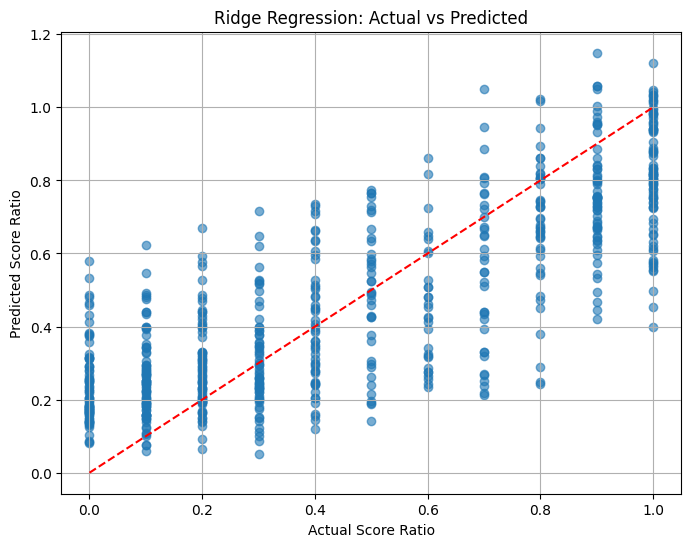

In [35]:

y_pred = reg_model.predict(X_scaled)

X_test_imputed = imputer.transform(X_holdout)
X_test_scaled = scaler.transform(X_test_imputed)
y_test_pred = reg_model.predict(X_test_scaled)

print("Test MSE:", mean_squared_error(y_holdout, y_test_pred))
print("Test MAE:", mean_absolute_error(y_holdout, y_test_pred))
print("Test R^2 Score:", r2_score(y_holdout, y_test_pred))

plt.figure(figsize=(8, 6))
plt.scatter(y_train_main, y_pred, alpha=0.6)
plt.plot([y_train_main.min(), y_train_main.max()], [y_train_main.min(), y_train_main.max()], 'r--')
plt.xlabel("Actual Score Ratio")
plt.ylabel("Predicted Score Ratio")
plt.title("Ridge Regression: Actual vs Predicted")
plt.grid(True)
plt.show()
